In [1]:
#pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shap 
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')
df_MMRTNE = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv')
df_OECD = pd.read_csv('OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv')

In [3]:
######  select which df to use 

#df = df_MMRTNE
#indicator_y = 'SH.STA.MMRT.NE'

#df = df_MMRT
#indicator_y = 'SH.STA.MMRT'


df = df_OECD
indicator_y = 'MATIMATM'

# Perform hyper parameter tuning? 
perform_hp_tuning = False

## Simple Linear Regression

In [4]:
# First need to encode the country 

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy(deep = True)
data_encoded['Country'] = country_encoder.fit_transform(data_encoded['Country'])

In [5]:
# pull out Maternal Mortality as the predictor variable 
X = data_encoded.drop(columns= indicator_y)
y = data_encoded[indicator_y]

### 5 fold cross validation 

In [6]:
def five_fold_cv(model):
    
    # Create a list to store the mean squared errors (MSE) for each fold
    mse_scores = []
    r2_scores = []

    # Create a KFold cross-validator with 5 folds
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform 5-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]


        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate the mean squared error (MSE) for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

    # Calculate the mean and standard deviation of the MSE scores and r2 scores
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)

    print(f"Average Mean Squared Error (MSE): {mean_mse}")
    print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")
    print(f"Mean R-squared (R2): {mean_r2}")
    print(f"Standard Deviation of R-squared (R2): {std_r2}")

In [7]:
# Establish a linear regression model
model = LinearRegression()

# Run five-fold CV 
five_fold_cv(model)

Average Mean Squared Error (MSE): 1667.5024446267903
Standard Deviation of Mean Squared Error (MSE): 2267.7517852453334
Mean R-squared (R2): -12.187633597678628
Standard Deviation of R-squared (R2): 18.731980501118503


### Single Model Case, for interest and experimentation

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 819.1327663379587
R-squared: -1.9342699391772427


## Including Lasso Regression and Hyper-parameter Tuning

In [10]:

if perform_hp_tuning:
    # Create a Lasso regression model
    lasso_model = Lasso()

    # Define a range of alpha values to tune
    alpha_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,
                    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 
                    1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  

    # Create a parameter grid for GridSearchCV
    param_grid = {'alpha': alpha_values}

    # Create a GridSearchCV object with cross-validation
    grid_search = GridSearchCV(lasso_model, param_grid, cv=5)  

    # Fit the grid search to the data
    grid_search.fit(X, y)

    # Get the best alpha value
    best_alpha = grid_search.best_params_['alpha']

    # Get the best Lasso model
    best_lasso_model = grid_search.best_estimator_
    
else: 
    if indicator_y == 'MATIMATM':
        best_alpha = 0.06 # value found in hyperparameter tuning for OECD
    elif indicator_y == 'SH.STA.MMRT.NE': 
        best_alpha = 0.02 # value found in hyperparameter tuning for World Bank

In [11]:
# Establish Lasso model
lasso_model = Lasso(alpha=best_alpha)
# Run five-fold CV 
five_fold_cv(lasso_model)

Average Mean Squared Error (MSE): 21.067115270123686
Standard Deviation of Mean Squared Error (MSE): 3.062066279116321
Mean R-squared (R2): 0.8257226105201136
Standard Deviation of R-squared (R2): 0.07612660788564392


### A look into model performance

In [12]:
def plot_linear_reg(X, y, yp, country, title):

 # X - X_test
 # y - y_test
 # yp - y_pred
 # country - list of country abbreviations ie. ['USA']

    if country == None: 

        # Plot the data points and the regression line
        plt.figure(figsize=(30, 20))
        plt.scatter(X['Year'], y, color='blue', label='Data')
        plt.scatter(X['Year'], yp, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.figure(figsize=(30, 20))
        plt.show()
        
    else: 
        # Country encoding 
        encoded_values = country_encoder.transform(country)
        # looking at just the secific country predictions in test partition

        # Use boolean indexing to select the subset of the DataFrame
        condition = X['Country'].isin(encoded_values)
        X_test = X[condition]['Year']
        y_test = y.loc[X_test.index]

        # take the array index in order to pull the relevant y_pred  
        index_positions = [y.index.get_loc(index) for index in X_test.index]
        
        y_pred = [yp[i] for i in index_positions]
        
        # Plot the data points and the regression line
        plt.figure(figsize=(15, 10))
        plt.scatter(X_test, y_test, color='blue', label='Data')
        plt.scatter(X_test, y_pred, color='red',  label='Linear Regression')
        plt.xlabel('Year')
        plt.ylabel('Maternal Mortality Ratio')
        plt.title(title)
        plt.legend()
        plt.show()

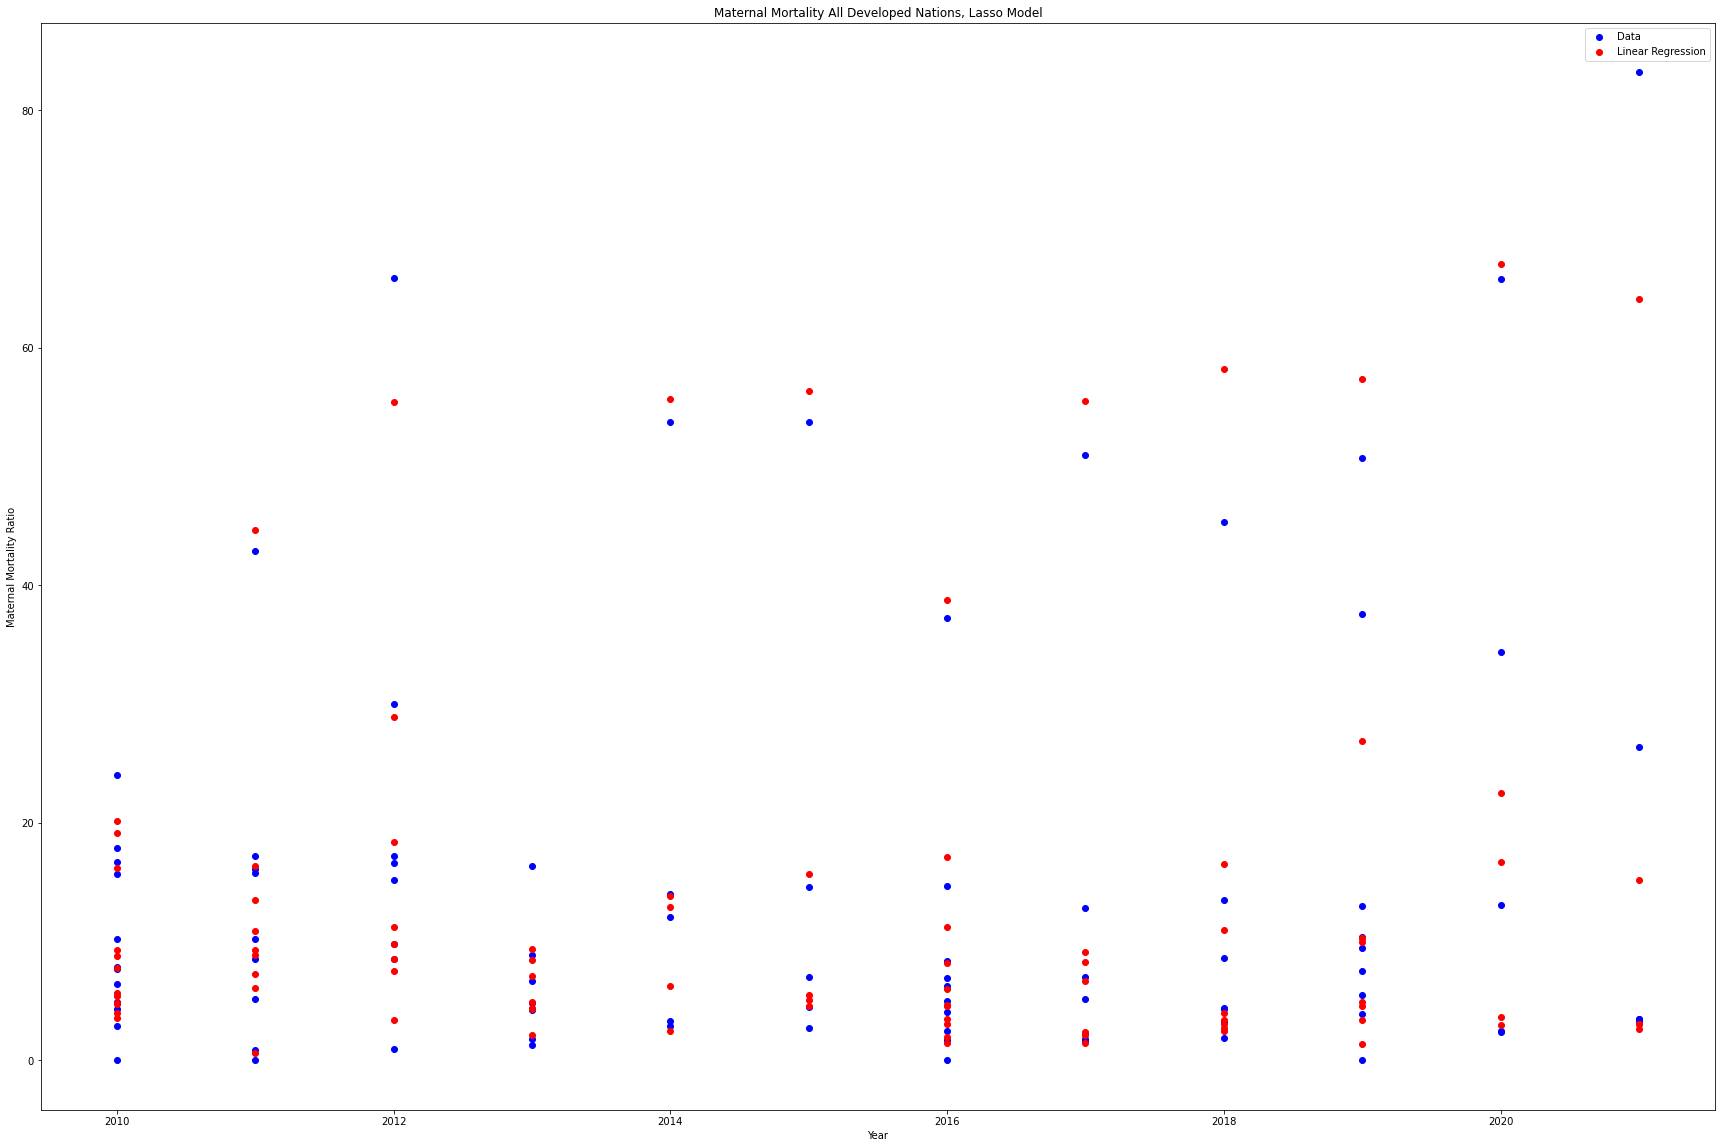

<Figure size 2160x1440 with 0 Axes>

In [13]:
# Make predictions on the test data for Lasso Model
y_pred_lasso = lasso_model.predict(X_test)

plot_linear_reg(X_test, y_test, y_pred_lasso, country = None, title = 'Maternal Mortality All Developed Nations, Lasso Model')

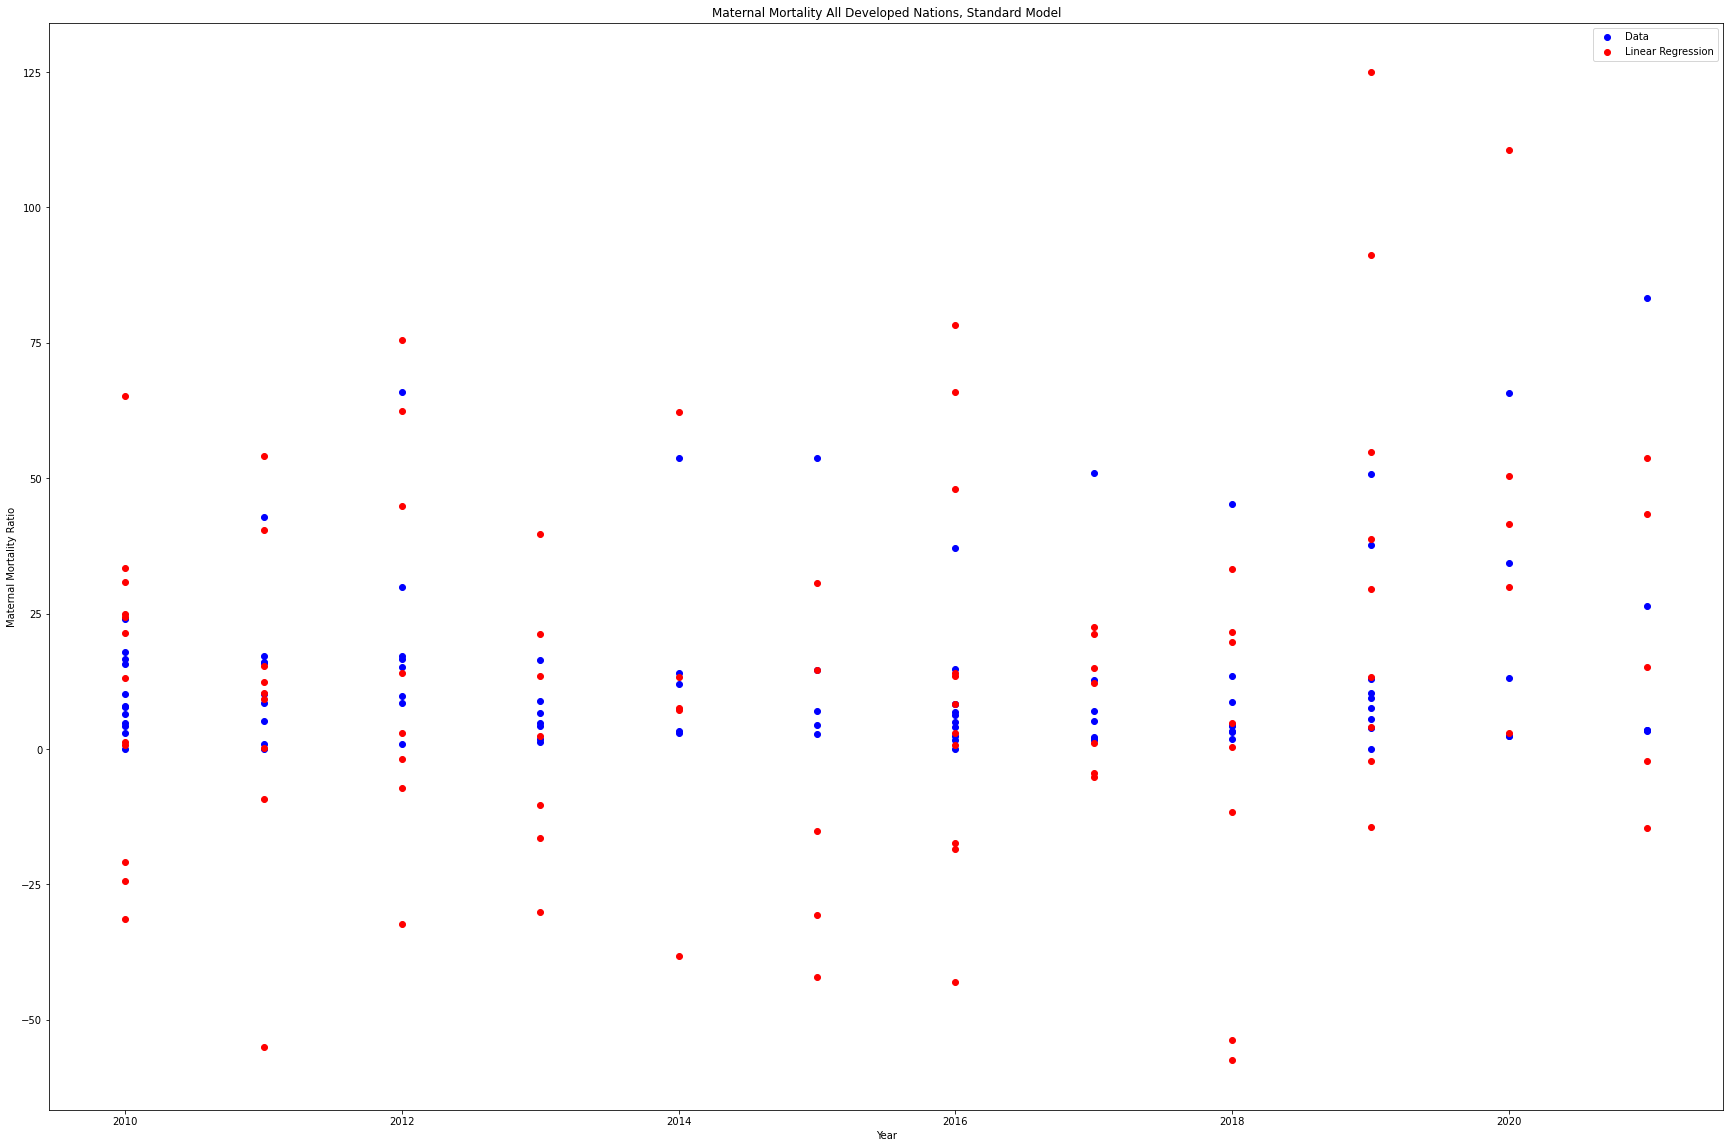

<Figure size 2160x1440 with 0 Axes>

In [14]:
# Make predictions on the test data for Regular linear regression model
y_pred = model.predict(X_test)

plot_linear_reg(X_test, y_test, y_pred, country = None, title = 'Maternal Mortality All Developed Nations, Standard Model')

In [15]:
#plot_linear_reg(X_test, y_test, y_pred, country = ['USA'], title = 'Maternal Mortality Predictions USA')

In [16]:
#plot_linear_reg(X_test, y_test, y_pred, country = ['DEU'], title = 'Maternal Mortality Predictions Germany')

In [17]:
#plot_linear_reg(X_test, y_test, y_pred, country = ['DEU', 'USA'], title = 'Maternal Mortality Predictions USA + Germany')

## Shapley Values

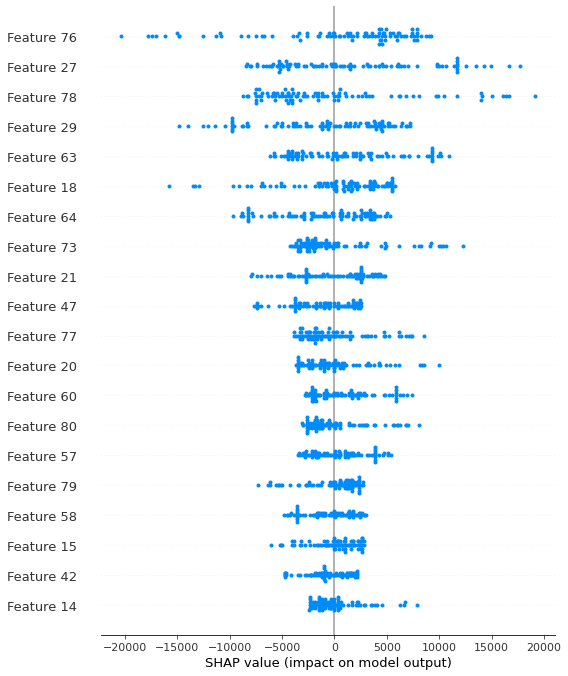

In [18]:
explainer = shap.LinearExplainer(model, X_train)

# look at the features for all instances
shap_values = explainer.shap_values(X_test) 

shap.summary_plot(shap_values)

#shap_values.shape

In [19]:
# Convert the Shapley values and the feature names into a DataFrame
shap_df = pd.DataFrame(data=shap_values, columns=X_test.columns)

# Pull the top shapley features 
top_features = shap_df.iloc[0, :].sort_values(ascending=False)
top_feature_names = top_features.index

# Display the top 10 features 
top_feature_names[:10]

Index(['ADMRDBUC_T_TOTAL_15_LOW_CI', 'ADMRCOPD_F_TOTAL_15_UP_CI',
       'ADMRDBUC_F_TOTAL_15_UP_CI', 'ADMRDBUC_M_TOTAL_15_UP_CI',
       'ADMRDBUC_T_TOTAL_15_AS_STD_RATE_MPOP',
       'ADMRDBUC_F_TOTAL_15_AS_STD_RATE_MPOP', 'ASCOCOMP_T_TOTAL_15_LOW_CI',
       'CICDNEOP', 'ASCOCOMP_F_TOTAL_15_AS_STD_RATE_MPOP',
       'PRPPANTI_T_TOTAL_65_AS_STD_RATE_MPOP'],
      dtype='object')

In [20]:
# look at the features for the USA predictions 
encoded_values = country_encoder.transform(['USA'])

condition = X_test['Country'].isin(encoded_values)
X_country_lens = X_test[condition]['Year']

shap_values = explainer.shap_values(X_test.loc[X_country_lens.index]) 
#shap.summary_plot(shap_values)

### A look at coeffecients 

In [21]:
# Get the coefficients and feature names
coefficients = model.coef_
feature_names =  X.columns 

# Create a dictionary with feature names and their coefficients
coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by their absolute coefficients in descending order
sorted_features = sorted(coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top 10 sorted features
for feature, coefficient in sorted_features[0:11]:
    print(f"{feature}: {coefficient}")

CHHYCOMP_M_TOTAL_15_AS_STD_RATE_MPOP: -30118.616831740837
ADMRCOPD_T_TOTAL_15_AS_STD_RATE_MPOP: 28890.3764730529
CHHYCOMP_M_TOTAL_15_UP_CI: 27837.766528981316
ADMRCOPD_T_TOTAL_15_UP_CI: -24451.387109039984
ADMRCHFL_T_TOTAL_15_AS_STD_RATE_MPOP: -21799.54649790297
ASCOCOMP_T_TOTAL_15_AS_STD_RATE_MPOP: 18555.96961384639
CHHYCOMP_F_TOTAL_15_AS_STD_RATE_MPOP: 16647.03018408606
ASCOCOMP_T_TOTAL_15_LOW_CI: -16147.655282660193
ADMRCOPD_F_TOTAL_15_AS_STD_RATE_MPOP: -15453.961445285044
ADMRCHFL_T_TOTAL_15_UP_CI: 13778.724789153446
CHHYCOMP_M_TOTAL_15_LOW_CI: 12896.201087406003
